In [1]:
import datetime, itertools
import pandas as ps

In [2]:
data = ps.read_csv("data/spelled-f.csv", sep=';', header=None,
                   index_col=0,names=['id','title','text','cluster','date','publisher'])

In [3]:
data = data[~data["cluster"].isin(("-", "S", "Standard "))]

## Количество связей между сообщениями

In [4]:
n_links = sum(len(df)*(len(df)-1)//2 for _, df in data.groupby("cluster"))
print("Всего связей:", n_links)

Всего связей: 25764


## Количество связей между сообщениями, опубликованными не в один день:

In [5]:
links_n1d = 0
for _, df in data.groupby("cluster"):
    for (_, r1), (_, r2) in itertools.combinations(df.iterrows(), 2):
        if r1["date"] != r2["date"]:
            links_n1d += 1
        #d1 = datetime.datetime.strptime(t1["date"], "%Y-%m-%d").date()
print("Связей с между днями:", links_n1d)
print("Максимальное падение полноты:", links_n1d/n_links)

Связей с между днями: 548
Максимальное падение полноты: 0.02126998913212234


## Количество связей между сообщениями, у которых один и тот же издатель:

In [6]:
links_1pub = 0
for _, df in data.groupby("cluster"):
    for (_, r1), (_, r2) in itertools.combinations(df.iterrows(), 2):
        if r1["publisher"] == r2["publisher"]:
            links_1pub += 1
print("Связей с одним издателем:", links_1pub)
print("Максимальное падение полноты:", links_1pub/n_links)

Связей с одним издателем: 68
Максимальное падение полноты: 0.00263934171712467


## Количество связей между сообшениями, у которых нет ни одного общего существительного:

In [7]:
from pymystem3 import Mystem
mystem = Mystem()

In [16]:
import nltk
stop_words = set(nltk.corpus.stopwords.words('russian'))
WEIRD_WORDS = set()

def get_message_nouns(msg):
    nouns = set()
    words = mystem.analyze(msg)
    for w in words:
        if "analysis" not in w:
            continue
        if w["analysis"] and "S" in w["analysis"][0]["gr"]:
            lex = w["analysis"][0]["lex"]
            if lex and len(lex) > 2 and lex not in stop_words:
                nouns.add(lex)
        elif not w["analysis"] and len(w["text"]) > 2:
            WEIRD_WORDS.add(w["text"])
            nouns.add(w["text"].lower())
    return nouns

In [17]:
links_n1s = 0
for _, df in data.groupby("cluster"):
    messages = [row["title"] + ". " + row["text"] for _, row in df.iterrows()]
    msg_nouns = [get_message_nouns(msg) for msg in messages]
    for n1, n2 in itertools.combinations(msg_nouns, 2):
        if not n1 & n2:
            links_n1s += 1
print("Связей без общих существительных:", links_n1s)
print("Максимальное падение полноты:", links_n1s/n_links)

Связей без общих существительных: 210
Максимальное падение полноты: 0.008150908244061481


In [19]:
print(sorted(WEIRD_WORDS))

['ABBA', 'ABC', 'ABN', 'ABOLA', 'ABS', 'ABT', 'ACB', 'ACR', 'ACRв', 'AEGON', 'AER', 'AFIRME', 'AFP', 'AIBA', 'AIR', 'ALASA', 'ALMA', 'AMD', 'AMG', 'AMRO', 'AMT', 'AMuS', 'APB', 'APU', 'APUkraine', 'ARD', 'ARM', 'ASUS', 'ASX', 'ATAP', 'ATP', 'ATR', 'ATS', 'ATV', 'AUTOSPORT', 'AVG', 'AVN', 'AWD', 'AZE', 'AZN', 'Abarth', 'Abell', 'Abendblatt', 'Abierto', 'Abominable', 'Abrams', 'Abroskin', 'Abyss', 'Academi', 'Academy', 'Accent', 'Access', 'Acer', 'Aces', 'Active', 'Activision', 'Actyon', 'Acura', 'AdBlock', 'Adblock', 'Adidas', 'Adriatik', 'Advanced', 'Advances', 'Aegea', 'Aegon', 'Aero', 'Afar', 'Afirme', 'Aftenposten', 'Age', 'Agence', 'Agera', 'Agnieszka', 'Agras', 'Aguero', 'Agusta', 'AiFAX', 'AiO', 'Air', 'AirCross', 'Airberlin', 'Airborne', 'Airbus', 'Aircross', 'Airlines', 'Airlinesза', 'Airways', 'Aktuality', 'Aktualne', 'Alaia', 'Alaska', 'Alaskan', 'Alberto', 'Alcatel', 'Aldi', 'Alenia', 'Alexander', 'Alfa', 'Algemeen', 'AliExpress', 'Alibaba', 'Alienware', 'Aliou', 'Alitalia',

In [21]:
clusters_ncs = 0
lost_links = 0
for clsname, df in data.groupby("cluster"):
    messages = [row["title"] + ". " + row["text"] for _, row in df.iterrows()]
    msg_nouns = [get_message_nouns(msg) for msg in messages]
    
    common_nouns = msg_nouns[0]
    for nouns in msg_nouns[1:]:
        common_nouns &= nouns
    
    if not common_nouns:
        clusters_ncs += 1
        lost_links += len(df)*(len(df)-1)//2

clusters_total = len(data["cluster"].unique())
print("Кластеров, у которых нет общих существительных:", clusters_ncs)
print("Кластеров всего:", clusters_total)
print("Соотношение:", clusters_ncs/clusters_total)
print("Потерянных связей:", lost_links)
print("Максимальное падение полноты:", lost_links/n_links)

Кластеров, у которых нет общих существительных: 260
Кластеров всего: 13213
Соотношение: 0.01967759025202452
Потерянных связей: 923
Максимальное падение полноты: 0.03582518242508927


## Эксперимент с подразбиением дня:

In [70]:
import networkx as nx
from networkx.algorithms.components import number_connected_components

def get_noun_messages(data_1d):
    msg_nouns = [{"id": ind, "nouns": get_message_nouns(row["title"] + ". " + row["text"])}
                 for ind, row in data_1d.iterrows()]
    noun_messages = {}
    for msg in msg_nouns:
        for noun in msg["nouns"]:
            if noun not in noun_messages:
                noun_messages[noun] = []
            noun_messages[noun].append(msg["id"])
    return noun_messages

def get_noun_graph(data_1d):
    noun_messages = get_noun_messages(data_1d)
    graph = nx.Graph()
    for noun, messages in noun_messages.items():
        for mi1, mi2 in itertools.combinations(messages, 2):
            graph.add_edge(mi1, mi2)
    return graph

In [ ]:
days_to_check = ['2015-11-29', '2015-09-26', '2015-09-28', '2015-03-28', '2015-08-30',
                '2015-10-25', '2015-06-25', '2015-05-25', '2015-05-26', '2015-05-30']
MIN_GROUP_COUNT = 20
for day in days_to_check:
    data_1d = data[data["date"] == day]
    noun_messages = get_noun_messages(data_1d)
    group_count = sum(1 for msgs in noun_messages.values() if len(msgs) >= MIN_GROUP_COUNT)
    msgs_in_group = set(m for msgs in noun_messages.values() for m in msgs if len(msgs) >= MIN_GROUP_COUNT)
    default_group = set(m for msgs in noun_messages.values() for m in msgs if m not in msgs_in_group)
    max_group_count = max(len(msgs) for msgs in noun_messages.values())
    
    graph = get_noun_graph(data_1d)
    print("Число сообщений:", len(data_1d))
    print("Число групп:", group_count)
    print("Базовая группа:", len(default_group))
    print("Максимальная группа:", max_group_count)
    print("Число компонент связности:", number_connected_components(graph))
    print("Двусвязен ли граф:", is_biconnected(graph), "\n")

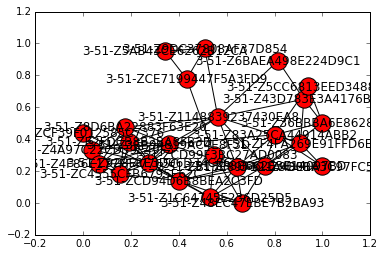

In [66]:
%matplotlib inline
data_1d = data[data["date"] == '2015-09-26']
messages = [row["title"] + ". " + row["text"] for _, row in data_1d.iterrows()]
all_nouns = [get_message_nouns(msg) for msg in messages]
#for msg, nouns in zip(messages, all_nouns):
#    print(msg, "\n", nouns, "\n")

graph = get_noun_graph(data_1d)
nx.draw_networkx(graph)